<h3>Import Packages<h3>

In [36]:
from sqlalchemy import create_engine
import pandas as pd
import talib
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import copy
from sklearn.model_selection import RandomizedSearchCV
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.externals import joblib
import seaborn as sns
import matplotlib.pyplot as plt

<h3>Connect to MySQL<h3>

Here I connect with MySQL database to load stock data 

In [71]:
def connect_sql(database,echo):
    engine = create_engine("mysql+pymysql://root:")
    return engine

engine = connect_sql('twse',False)
id = list(c.columns)
selecttex =  '''SELECT * FROM specialtopics.'''
ordertext =  ''' ORDER BY mdate ASC;'''
text = 'id'

<h3>Create Dataframe For a Stock<h3>

For this train, I use Taiwan Semiconductor Manufacturing(TSMC), stock id 2330,as an example to train the model, then load the stock data from MySQL and Create a dataframe for TSMC.

In [72]:
stockid = '2330'
idtext = text + stockid
sqltext = selecttex + idtext + ordertext
df = pd.read_sql_query(sqltext, engine, index_col='mdate')
close = df['close_adj']
volume=df['volume']
low=df['low_adj']
high=df['high_adj']
open_=df['open_adj']
df.head()

,open_adj,close_adj,high_adj,low_adj,volume
mdate,,,,,
2007-01-02,38.33,38.27,38.44,38.05,26080.0
2007-01-03,38.33,38.44,38.84,38.16,42087.0
2007-01-04,38.27,38.27,38.50,38.22,22326.0
2007-01-05,38.16,37.82,38.27,37.59,30580.0
2007-01-08,37.37,37.20,37.59,37.14,24177.0


<h3>Create 140 Technical Indicators For Model Training<h3>

Ues stock data including, open_adj, close_adj, high_adj, low_adj, volume to create 140 technical indicators. You can find the explanation for each indicators at https://github.com/mrjbq7/ta-lib

In [52]:

ad = talib.AD(high, low, close, volume)
adosc1 = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=7)
adosc2 = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
adosc3 = talib.ADOSC(high, low, close, volume, fastperiod=4, slowperiod=10)
adosc4 = talib.ADOSC(high, low, close, volume, fastperiod=5, slowperiod=10)
adosc5 = talib.ADOSC(high, low, close, volume, fastperiod=6, slowperiod=10)
adosc6 = talib.ADOSC(high, low, close, volume, fastperiod=7, slowperiod=10)
adosc7 = talib.ADOSC(high, low, close, volume, fastperiod=5, slowperiod=12)
adosc8 = talib.ADOSC(high, low, close, volume, fastperiod=5, slowperiod=14)
adosc9 = talib.ADOSC(high, low, close, volume, fastperiod=7, slowperiod=14)
adosc10 = talib.ADOSC(high, low, close, volume, fastperiod=4, slowperiod=10)
obv = talib.OBV(close, volume)

#Overlap Studies Functions  mavp 
upperband1, middleband1, lowerband1 = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
upperband2, middleband2, lowerband2 = talib.BBANDS(close, timeperiod=10, nbdevup=2, nbdevdn=2, matype=0)
dema1 = talib.DEMA(close, timeperiod=2)
dema2 = talib.DEMA(close, timeperiod=3)
dema3 = talib.DEMA(close, timeperiod=4)
dema4 = talib.DEMA(close, timeperiod=5)
dema5 = talib.DEMA(close, timeperiod=6)
dema6 = talib.DEMA(close, timeperiod=7)
dema7 = talib.DEMA(close, timeperiod=8)
dema8 = talib.DEMA(close, timeperiod=9)
dema9 = talib.DEMA(close, timeperiod=10)
dema10 = talib.DEMA(close, timeperiod=12)
dema11 = talib.DEMA(close, timeperiod=14)
dema12 = talib.DEMA(close, timeperiod=15)
dema13 = talib.DEMA(close, timeperiod=16)
dema14 = talib.DEMA(close, timeperiod=18)
dema15 = talib.DEMA(close, timeperiod=20)
dema16 = talib.DEMA(close, timeperiod=30)#原始參數
dema17 = talib.DEMA(close, timeperiod=40)
dema18 = talib.DEMA(close, timeperiod=60)
dema19 = talib.DEMA(close, timeperiod=90)
dema20 = talib.DEMA(close, timeperiod=120)
ema1= talib.EMA(close, timeperiod=5)
ema2= talib.EMA(close, timeperiod=10)
ema3= talib.EMA(close, timeperiod=12)
ema4= talib.EMA(close, timeperiod=26)
ema5= talib.EMA(close, timeperiod=30)
ema6= talib.EMA(close, timeperiod=60)
htt = talib.HT_TRENDLINE(close)
kama1 = talib.KAMA(close, timeperiod=3)
kama2 = talib.KAMA(close, timeperiod=5)
kama3 = talib.KAMA(close, timeperiod=10)
kama4 = talib.KAMA(close, timeperiod=15)
kama5 = talib.KAMA(close, timeperiod=20)
kama6 = talib.KAMA(close, timeperiod=30)
kama7 = talib.KAMA(close, timeperiod=60)
#日線、3日線、週線、雙週線、三週線、月線、雙月線、季線、半年線、年線
ma1 = talib.MA(close, timeperiod=1, matype=0)
ma2 = talib.MA(close, timeperiod=3, matype=0)
ma3 = talib.MA(close, timeperiod=5, matype=0)
ma4 = talib.MA(close, timeperiod=10, matype=0)
ma5 = talib.MA(close, timeperiod=15, matype=0)
ma6 = talib.MA(close, timeperiod=20, matype=0)
ma7 = talib.MA(close, timeperiod=40, matype=0)
ma8 = talib.MA(close, timeperiod=60, matype=0)
ma9 = talib.MA(close, timeperiod=120, matype=0)
ma10 = talib.MA(close, timeperiod=250, matype=0)
mama, fama = talib.MAMA(close, fastlimit=0.5, slowlimit=0.05)
#'mavp': talib.MAVP(close, periods = ? , minperiod=2, maxperiod=30, matype=0),
#midpoint反應價格變動的極值,是收盤價最大值和最小值的平均值
midpoint1 = talib.MIDPOINT(close, timeperiod=2)#不能設1
midpoint2 = talib.MIDPOINT(close, timeperiod=3)
midpoint3 = talib.MIDPOINT(close, timeperiod=5)
midpoint4 = talib.MIDPOINT(close, timeperiod=10)
midpoint5 = talib.MIDPOINT(close, timeperiod=14)
midpoint6 = talib.MIDPOINT(close, timeperiod=15)
midpoint7 = talib.MIDPOINT(close, timeperiod=20)
midpoint8 = talib.MIDPOINT(close, timeperiod=40)
midpoint9 = talib.MIDPOINT(close, timeperiod=60)
#midprice選擇的是週期內最高價的最大值和最低價的最小值作為參數
midprice1 = talib.MIDPRICE(high, low, timeperiod=2)
midprice2 = talib.MIDPRICE(high, low, timeperiod=3)
midprice3 = talib.MIDPRICE(high, low, timeperiod=5)
midprice4 = talib.MIDPRICE(high, low, timeperiod=10)
midprice5 = talib.MIDPRICE(high, low, timeperiod=14)
midprice6 = talib.MIDPRICE(high, low, timeperiod=15)
midprice7 = talib.MIDPRICE(high, low, timeperiod=20)
midprice8 = talib.MIDPRICE(high, low, timeperiod=40)
midprice9 = talib.MIDPRICE(high, low, timeperiod=60)
sar = talib.SAR(high, low, acceleration=0.02, maximum=0.2)
sarext = talib.SAREXT(high, low, startvalue=0, offsetonreverse=0, accelerationinitlong=0.02, accelerationlong=0.02, accelerationmaxlong=0.2, accelerationinitshort=0.02, accelerationshort=0.02, accelerationmaxshort=0.2)
#簡單移動平均，將過去某特定時間內的向量值取其平均值
sma1 = talib.SMA(close, timeperiod=2)
sma2 = talib.SMA(close, timeperiod=3)
sma3 = talib.SMA(close, timeperiod=5)
sma4 = talib.SMA(close, timeperiod=10)
sma5 = talib.SMA(close, timeperiod=14)
sma6 = talib.SMA(close, timeperiod=20)
sma7 = talib.SMA(close, timeperiod=30)
sma8 = talib.SMA(close, timeperiod=50)
sma9 = talib.SMA(close, timeperiod=60)
sma10 = talib.SMA(close, timeperiod=100)
sma11 = talib.SMA(close, timeperiod=200)
t3_1 = talib.T3(close, timeperiod=3, vfactor=0.7)
t3_2 = talib.T3(close, timeperiod=5, vfactor=0.7)
t3_3 = talib.T3(close, timeperiod=7, vfactor=0.7)
t3_4 = talib.T3(close, timeperiod=10, vfactor=0.7)
t3_5 = talib.T3(close, timeperiod=15, vfactor=0.7)
t3_6 = talib.T3(close, timeperiod=20, vfactor=0.7)
t3_7 = talib.T3(close, timeperiod=40, vfactor=0.7)
t3_8 = talib.T3(close, timeperiod=60, vfactor=0.7)
t3_9 = talib.T3(close, timeperiod=120, vfactor=0.7)
tema1 = talib.TEMA(close, timeperiod=5)
tema2 = talib.TEMA(close, timeperiod=10)
tema3 = talib.TEMA(close, timeperiod=12)
tema4 = talib.TEMA(close, timeperiod=26)
tema5 = talib.TEMA(close, timeperiod=30)
tema6 = talib.TEMA(close, timeperiod=60)
trima1 = talib.TRIMA(close, timeperiod=5)
trima2 = talib.TRIMA(close, timeperiod=10)
trima3 = talib.TRIMA(close, timeperiod=30)
trima4 = talib.TRIMA(close, timeperiod=60)
wma1 = talib.WMA(close, timeperiod=5)
wma2 = talib.WMA(close, timeperiod=10)
wma3 = talib.WMA(close, timeperiod=30)
wma4 = talib.WMA(close, timeperiod=60)
#Momentum Indicator
adx1 = talib.ADX(high, low, close, timeperiod=7)
adx2 = talib.ADX(high, low, close, timeperiod=10)
adx3 = talib.ADX(high, low, close, timeperiod=14)#起始參數為14
adx4 = talib.ADX(high, low, close, timeperiod=15)
adx5= talib.ADX(high, low, close, timeperiod=20)
adx6 = talib.ADX(high, low, close, timeperiod=28)
adx7 = talib.ADX(high, low, close, timeperiod=5)
adx8 = talib.ADX(high, low, close, timeperiod=25)
adxr1 = talib.ADXR(high, low, close, timeperiod=7)
adxr2 = talib.ADXR(high, low, close, timeperiod=10)
adxr3 = talib.ADXR(high, low, close, timeperiod=14)#起始參數為14
adxr4 = talib.ADXR(high, low, close, timeperiod=15)
adxr5= talib.ADXR(high, low, close, timeperiod=20)
adxr6 = talib.ADXR(high, low, close, timeperiod=28)
apo1 = talib.APO(close, fastperiod=6, slowperiod=13, matype=0)
apo2 = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)#內建
aroondown1, aroonup1 = talib.AROON(high, low, timeperiod=7)
aroondown2, aroonup2 = talib.AROON(high, low, timeperiod=14)
aroondown3, aroonup3 = talib.AROON(high, low, timeperiod=25)
aroonosc1 = talib.AROONOSC(high, low, timeperiod=7)
aroonosc2 = talib.AROONOSC(high, low, timeperiod=14)
aroonosc3 = talib.AROONOSC(high, low, timeperiod=25)
bop = talib.BOP(open_, high, low, close)
cci1 = talib.CCI(high, low, close, timeperiod=7)
cci2 = talib.CCI(high, low, close, timeperiod=14)
cci3 = talib.CCI(high, low, close, timeperiod=28)
cmo1 = talib.CMO(close, timeperiod=7)
cmo2 = talib.CMO(close, timeperiod=14)
cmo3 = talib.CMO(close, timeperiod=28)
dx1 = talib.DX(high, low, close, timeperiod=7)
dx2 = talib.DX(high, low, close, timeperiod=14)
dx3 = talib.DX(high, low, close, timeperiod=28)
macd1, macdsignal1, macdhist1 = talib.MACD(close, fastperiod=8, slowperiod=13, signalperiod=9)
macd2, macdsignal2, macdhist2 = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
mfi1 = talib.MFI(high, low, close, volume, timeperiod=5)
mfi2 = talib.MFI(high, low, close, volume, timeperiod=7)
mfi3 = talib.MFI(high, low, close, volume, timeperiod=10)
mfi4 = talib.MFI(high, low, close, volume, timeperiod=14)#原始參數
mfi5 = talib.MFI(high, low, close, volume, timeperiod=15)
mfi6 = talib.MFI(high, low, close, volume, timeperiod=28)
minus_di1 =talib.MINUS_DI(high, low, close, timeperiod=5)
minus_di2 =talib.MINUS_DI(high, low, close, timeperiod=7)
minus_di3 =talib.MINUS_DI(high, low, close, timeperiod=10)
minus_di4 =talib.MINUS_DI(high, low, close, timeperiod=14)#原始參數
minus_di5 =talib.MINUS_DI(high, low, close, timeperiod=15)
minus_di6 =talib.MINUS_DI(high, low, close, timeperiod=28)
minus_dm1 = talib.MINUS_DM(high, low, timeperiod=5)
minus_dm2 = talib.MINUS_DM(high, low, timeperiod=7)
minus_dm3 = talib.MINUS_DM(high, low, timeperiod=10)
minus_dm4 = talib.MINUS_DM(high, low, timeperiod=14)#原始參數
minus_dm5 = talib.MINUS_DM(high, low, timeperiod=15)
minus_dm6 = talib.MINUS_DM(high, low, timeperiod=28)
mom1 = talib.MOM(close, timeperiod=5)
mom2 = talib.MOM(close, timeperiod=10)#原始參數
mom3 = talib.MOM(close, timeperiod=15)
mom4 = talib.MOM(close, timeperiod=20)
plus_di1 =talib.PLUS_DI(high, low, close, timeperiod=5)
plus_di2 =talib.PLUS_DI(high, low, close, timeperiod=7)
plus_di3 =talib.PLUS_DI(high, low, close, timeperiod=10)
plus_di4 =talib.PLUS_DI(high, low, close, timeperiod=14)#原始參數
plus_di5 =talib.PLUS_DI(high, low, close, timeperiod=15)
plus_di6 =talib.PLUS_DI(high, low, close, timeperiod=28)
plus_dm1 =talib.PLUS_DM(high, low, timeperiod=5)
plus_dm2 =talib.PLUS_DM(high, low, timeperiod=7)
plus_dm3 =talib.PLUS_DM(high, low, timeperiod=10)
plus_dm4 =talib.PLUS_DM(high, low, timeperiod=14)#原始參數
plus_dm5 =talib.PLUS_DM(high, low, timeperiod=15)
plus_dm6 =talib.PLUS_DM(high, low, timeperiod=28)
ppo1 = talib.PPO(close, fastperiod=6, slowperiod=13, matype=0)
ppo2 = talib.PPO(close, fastperiod=8, slowperiod=13, matype=0)
ppo3 = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
roc1 = talib.ROC(close, timeperiod=5)
roc2 = talib.ROC(close, timeperiod=10)#原始參數
roc3 = talib.ROC(close, timeperiod=15)
roc4 = talib.ROC(close, timeperiod=20)
rocp1 = talib.ROCP(close, timeperiod=5)
rocp2 = talib.ROCP(close, timeperiod=10)#原始參數
rocp3 = talib.ROCP(close, timeperiod=15)
rocp4 = talib.ROCP(close, timeperiod=20)
rocr1 = talib.ROCR(close, timeperiod=5)
rocr2 = talib.ROCR(close, timeperiod=10)#原始參數
rocr3 = talib.ROCR(close, timeperiod=15)
rocr4 = talib.ROCR(close, timeperiod=20)
rsi1 = talib.RSI(close, timeperiod=3)
rsi2 = talib.RSI(close, timeperiod=6)
rsi3 = talib.RSI(close, timeperiod=12)
rsi4 = talib.RSI(close, timeperiod=7)
rsi5 = talib.RSI(close, timeperiod=14)#原始參數
rsi6 = talib.RSI(close, timeperiod=28)
slowk1, slowd1 = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)#原始參數
slowk2, slowd2 = talib.STOCH(high, low, close, fastk_period=9, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
fastk1, fastd1 = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)#原始參數
fastk2, fastd2 = talib.STOCHF(high, low, close, fastk_period=9, fastd_period=3, fastd_matype=0)
rfastk1, rfastd1 = talib.STOCHRSI(close, timeperiod=7, fastk_period=5, fastd_period=3, fastd_matype=0)
rfastk2, rfastd2 = talib.STOCHRSI(close, timeperiod=7, fastk_period=9, fastd_period=3, fastd_matype=0)
rfastk3, rfastd3 = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)#原始參數
rfastk4, rfastd4 = talib.STOCHRSI(close, timeperiod=14, fastk_period=9, fastd_period=3, fastd_matype=0)
trix1 = talib.TRIX(close, timeperiod=5)
trix2 = talib.TRIX(close, timeperiod=10)
trix3 = talib.TRIX(close, timeperiod=12)
trix4 = talib.TRIX(close, timeperiod=26)
trix5 = talib.TRIX(close, timeperiod=30)#原始參數
trix6 = talib.TRIX(close, timeperiod=60)
ultosc1 = talib.ULTOSC(high, low, close, timeperiod1=3, timeperiod2=7, timeperiod3=14)
ultosc2 = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)#原始參數
ultosc3 = talib.ULTOSC(high, low, close, timeperiod1=14, timeperiod2=28, timeperiod3=56)
willr1 =talib. WILLR(high, low, close, timeperiod=7)
willr2 =talib. WILLR(high, low, close, timeperiod=14)#原始參數
willr3 =talib. WILLR(high, low, close, timeperiod=28)
#Volatility Indicator
ATR1 = talib.ATR(high, low, close, timeperiod=7)
ATR2 = talib.ATR(high, low, close, timeperiod=14)
ATR3 = talib.ATR(high, low, close, timeperiod=28)
NATR1 = talib.NATR(high, low, close, timeperiod=7)
NATR2 = talib.NATR(high, low, close, timeperiod=14)
NATR3 = talib.NATR(high, low, close, timeperiod=28)
TRANGE = talib.TRANGE(high, low, close)

#Price Transform 
avgprice = talib.AVGPRICE(open_, high, low, close)
medprice = talib.MEDPRICE(high, low)
trpprice = talib.TYPPRICE(high, low, close)
wclprice = talib.WCLPRICE(high, low, close)

#Cycle Indicator 
ht_dcperiod = talib.HT_DCPERIOD(close)
ht_dcphace = talib.HT_DCPHASE(close)
inphase, quadrature = talib.HT_PHASOR(close)
sine, leadsine = talib.HT_SINE(close)
ht_trendmode = talib.HT_TRENDMODE(close)

<h3>Create Dataset for 140 Technical Indicatorss<h3>

In [53]:
dataset = pd.DataFrame({
    #Volume Indicator
    'ad': talib.AD(high, low, close, volume),
    'adosc fastperiod=3 slowperiod=7' : adosc1,
    'adoscfastperiod=3 slowperiod=10' : adosc2,
    'adoscfastperiod=4 slowperiod=10' : adosc3,
    'adoscfastperiod=5 slowperiod=10' : adosc4,
    'adoscfastperiod=6 slowperiod=10' : adosc5,
    'adoscfastperiod=7 slowperiod=10' : adosc6,
    'adoscfastperiod=5 slowperiod=12' : adosc7,
    'adoscfastperiod=5 slowperiod=14' : adosc8,
    'adoscfastperiod=7 slowperiod=14' : adosc9,
    'adoscfastperiod=4 slowperiod=10' : adosc10,
    'obv' : talib.OBV(close, volume),
    #Overlap Studies 
    'upperband timeperiod=5':upperband1,
    'middleband timeperiod=5':middleband1,
    'lowerband timeperiod=5':lowerband1,
    'upperband timeperiod=10':upperband2,
    'middleband timeperiod=10':middleband2,
    'lowerband timeperiod=10':lowerband2,
    'dema timeperiod=2' : dema1,
    'dema timeperiod=3' : dema2,
    'dema timeperiod=4' : dema3,
    'dema timeperiod=5' : dema4,
    'dema time eriod=6' : dema5,
    'dema timeperiod=7' : dema6,
    'dema timeperiod=8' : dema7,
    'dema timeperiod=9' : dema8,
    'dema time eriod=10' : dema9,
    'dema timeperiod=12' : dema10,
    'dema timeperiod=14' : dema11,
    'dema timeperiod=15' : dema12,
    'dema timeperiod=16' : dema13,
    'dema timeperiod=18' : dema14,
    'dema timeperiod=20' : dema15,
    'dema timeperiod=30' : dema16,
    'dema timeperiod=40' : dema17,
    'dema timeperiod=60' : dema18,
    'dema timeperiod=90' : dema19,
    'dema timeperiod=120' : dema20,
    'ema timeperiod=5' : ema1,
    'ema timeperiod=10' : ema2,
    'ema timeperiod=12' : ema3,
    'ema timeperiod=26' : ema4,
    'ema timeperiod=30' : ema5,
    'ema timeperiod=60' : ema6,
    'htt' : htt,
    'kama timeperiod=3' : kama1,
    'kama timeperiod=5' : kama2,
    'kama timeperiod=10' : kama3,
    'kama timeperiod=15' : kama4,
    'kama timeperiod=20' : kama5,
    'kama timeperiod=30' : kama6,
    'kama timeperiod=60' : kama7,
    'ma timeperiod=1': ma1,
    'ma timeperiod=3': ma2,
    'ma timeperiod=5': ma3,
    'ma timeperiod=10' : ma4,
    'ma timeperiod=15' : ma5,
    'ma timeperiod=20' : ma6,
    'ma timeperiod=40' : ma7,
    'ma timeperiod=60' : ma8,
    'ma timeperiod=120' : ma9,
    'ma timeperiod=250' : ma10,
    'mama': mama,
    'fama': fama,
    'midpoint timeperiod=2' : midpoint1,
    'midpoint timeperiod=3' : midpoint2,
    'midpoint timeperiod=5' : midpoint3,
    'midpoint timeperiod=10' : midpoint4,
    'midpoint timeperiod=14' : midpoint5,
    'midpoint timeperiod=15' : midpoint6,
    'midpoint timeperiod=20' : midpoint7,
    'midpoint timeperiod=40' : midpoint8,
    'midpoint timeperiod=60' : midpoint9,
    'midprice timeperiod=2' : midprice1,
    'midprice timeperiod=3' : midprice2,
    'midprice timeperiod=5' : midprice3,
    'midprice timeperiod=10' : midprice4,
    'midprice timeperiod=14' : midprice5,
    'midprice timeperiod=15' : midprice6,
    'midprice timeperiod=20' : midprice7,
    'midprice timeperiod=40' : midprice8,
    'midprice timeperiod=60' : midprice9,
    'sar' : sar,
    'sarext' : sarext,    
    'sma timeperiod=2' : sma1,
    'sma timeperiod=3' : sma2,
    'sma timeperiod=5' : sma3,
    'sma timeperiod=10 ' : sma4,
    'sma timeperiod=14 ' : sma5,
    'sma timeperiod=20 ' : sma6,
    'sma timeperiod=30' : sma7,
    'sma timeperiod=50' : sma8,
    'sma timeperiod=60' : sma9,
    'sma timeperiod=100' : sma10,
    'sma timeperiod=200' : sma11,
    't3 timeperiod=3' : t3_1,
    't3 timeperiod=5' : t3_2,
    't3 timeperiod=7' : t3_3,
    't3 timeperiod=10 ' : t3_4,
    't3 timeperiod=15 ' : t3_5,
    't3 timeperiod=20 ' : t3_6,
    't3 timeperiod=40 ' : t3_7,
    't3 timeperiod=60 ' : t3_8,
    't3 timeperiod=120' : t3_9,
    'tema timeperiod=5' : tema1,
    'tema timeperiod=10' : tema2,
    'tema timeperiod=12' : tema3,
    'tema timeperiod=26' : tema4,
    'tema timeperiod=30' : tema5,
    'tema timeperiod=60' : tema6,
    'trima timeperiod=5' : trima1,
    'trima timeperiod=10' : trima2,
    'trima timeperiod=30' : trima3,
    'trima timeperiod=60' : trima4,
    'wma timeperiod=5' : wma1,
    'wma timeperiod=10' : wma2,
    'wma timeperiod=30' : wma3,
    'wma timeperiod=60' : wma4,
#     #Momentum Indicator
    'adx timeperiod=5' : adx7,
    'adx timeperiod=7' : adx1,
    'adx timeperiod=10' : adx2,
    'adx timeperiod=14' : adx3,
    'adx timeperiod=15' : adx4,
    'adx timeperiod=20' : adx5,
    'adx timeperiod=25' : adx8,
    'adx timeperiod=28' : adx6,
    'adxr timeperiod=7' : adxr1,
    'adxr timeperiod=10' : adxr2,
    'adxr timeperiod=14' : adxr3,
    'adxr timeperiod=15' : adxr4,
    'adxr timeperiod=20' : adxr5,
    'adxr timeperiod=28' : adxr6,
    'ap fastperiod=6 slowperiod=13' : apo1,
    'apo fastperiod=13 slowperiod=26' : apo2,
    'aroonup timeperiod=7' : aroonup1 ,
    'aroondown timeperiod=7' : aroondown1,
    'aroonup timeperiod=14 ' : aroonup2 ,
    'aroondown timeperiod=14' : aroondown2,
    'aroonup timeperiod=25 ' : aroonup3 ,
    'aroondown timeperiod=25' : aroondown3,
    'aroonosc timeperiod=7' : aroonosc1,
    'aroonosc timeperiod=14' : aroonosc2,
    'aroonosc timeperiod=25' : aroonosc3,
    'bop' : bop,
    'cci timeperiod=7' : cci1,
    'cci timeperiod=14 ' : cci2,
    'cci timeperiod=28 ' : cci3,
    'cmo timeperiod=7' : cmo1,
    'cmo timeperiod=14' : cmo2,
    'cmo timeperiod=28' : cmo3,
    'dx timeperiod=7' : dx1,
    'dx timeperiod=14' : dx2,
    'dx timeperiod=28' : dx3,
    'macd fastperiod=8 slowperiod=13 signalperiod=9':macd1,
    'macd fastperiod=12 slowperiod=26 signalperiod=9':macd2,
    'mfi timeperiod=5 ' : mfi1,
    'mfi timeperiod=7 ' : mfi2,
    'mfi timeperiod=10' : mfi3,
    'mfi timeperiod=14' : mfi4,
    'mfi timeperiod=15' : mfi5,
    'mfi timeperiod=28' : mfi6,
    'minus_di timeperiod=5' : minus_di1,
    'minus_di timeperiod=7' : minus_di2,
    'minus_di timeperiod=10' : minus_di3,
    'minus_di timeperiod=14' : minus_di4,
    'minus_di timeperiod=15 ' : minus_di5,
    'minus_dm timeperiod=28' : minus_di6,
    'minus_dm timeperiod=5' : minus_dm1,
    'minus_dm timeperiod=7' : minus_dm2,
    'minus_dm timeperiod=10' : minus_dm3,
    'minus_dm timeperiod=14' : minus_dm4,
    'minus_dm timeperiod=15' : minus_dm5,
    'minus_dm timeperiod=28' : minus_dm6,
    'mom timeperiod=5' : mom1,
    'mom timeperiod=10' : mom2,
    'mom timeperiod=15' : mom3,
    'mom timeperiod=20' : mom4,
    'plus_di timeperiod=5' : plus_di1,
    'plus_di timeperiod=7' : plus_di2,
    'plus_di timeperiod=10' : plus_di3,
    'plus_di timeperiod=14' : plus_di4,
    'plus_di timeperiod=15' : plus_di5,
    'plus_di timeperiod=28' : plus_di6,
    'plus_dm timeperiod=5' : plus_dm1,
    'plus_dm timeperiod=7' : plus_dm2,
    'plus_dm timeperiod=10' : plus_dm3,
    'plus_dm timeperiod=14' : plus_dm4,
    'plus_dm timeperiod=15' : plus_dm5,
    'plus_dm timeperiod=28' : plus_dm6,
    'ppo fastperiod=6 slowperiod=13' : ppo1,
    'ppo fastperiod=8 slowperiod=13' : ppo2,
    'ppo fastperiod=12 slowperiod=26' : ppo3,
    'roc timeperiod=5' : roc1,
    'roc timeperiod=10' : roc2,
    'roc timeperiod=15' : roc3,
    'roc timeperiod=20' : roc4,    
    'rocp timeperiod=5' : rocp1,
    'rocp timeperiod=10' : rocp2,
    'rocp timeperiod=15' : rocp3,
    'rocp timeperiod=20' : rocp4,    
    'rocr timeperiod=5' : rocr1,
    'rocr timeperiod=10 ' : rocr2,
    'rocr timeperiod=15 ' : rocr3,
    'rocr timeperiod=20 ' : rocr4,
    'rsi timeperiod=3 ' : rsi1,
    'rsi timeperiod=6 ' : rsi2,
    'rsi timeperiod=12' : rsi3,
    'rsi timeperiod=7' : rsi4,
    'rsi timeperiod=14' : rsi5,
    'rsi timeperiod=28' : rsi6,
    'STOCH fastk_period=5 slowk_period=3 slowk_matype=0 slowd_period=3 slowd_matype=0' : slowk1 - slowd1,
    'STOCH fastk_period=9 slowk_period=3 slowk_matype=0 slowd_period=3 slowd_matype=0' : slowk2 - slowd2,
    'STOCHF fastk_period=5 fastd_period=3 fastd_matype=0' : fastk1 - fastd1,
    'STOCHF fastk_period=9 fastd_period=3 fastd_matype=0' : fastk2 - fastd2,
    'STOCHRSI timeperiod=7 fastk_period=5 fastd_period=3 fastd_matype=0' : rfastk1 - rfastd1,
    'STOCHRSI timeperiod=7 fastk_period=9 fastd_period=3 fastd_matype=0' : rfastk2 - rfastd2,
    'STOCHRSI timeperiod=14 fastk_period=5 fastd_period=3 fastd_matype=0' : rfastk3 - rfastd3,
    'STOCHRSI timeperiod=14 fastk_period=9 fastd_period=3 fastd_matype=0' : rfastk4 - rfastd4,
    'trix timeperiod=5': trix1,
    'trix timeperiod=10': trix2,
    'trix timeperiod=12': trix3,
    'trix timeperiod=26': trix4,
    'trix timeperiod=30': trix5,
    'trix timeperiod=60': trix6,
    'ultosc timeperiod1=3 timeperiod2=14 timeperiod3=28' : ultosc1,
    'ultosc timeperiod1=7 timeperiod2=14 timeperiod3=28' : ultosc2,
    'ultosc timeperiod1=14 timeperiod2=28 timeperiod3=56' : ultosc3,
    'willr timeperiod=7' : willr1,
    'willr timeperiod=14' : willr2,
    'willr timeperiod=28' : willr3,
    #Volatility Indicator
    'ATR timeperiod=7' : ATR1,
    'ATR timeperiod=14' : ATR2,
    'ATR timeperiod=28' : ATR3,
    'NATR timeperiod=7' : NATR1,
    'NATR timeperiod=14' : NATR2,
    'NATR timeperiod=28' : NATR3,
    'TRANGE' : TRANGE,
    #Price Transform 
    'avgprice' : avgprice,
    'medprice' : medprice,
    'trpprice' : trpprice,
    'wclprice' : wclprice,
    #Cycle Indicator 
    'ht_dcperiod' : ht_dcperiod,
    'ht_dcphace' : ht_dcphace,
    'ht_phasor_inphase' : inphase,
    'ht_phasor_quadrature' : quadrature,
    'ht_SINE_sine' : sine,
    'ht_SINE_LEADSINE' : leadsine,
    'ht_trendmode' : ht_trendmode,
    
    'return': open_.shift(-1) / open_,
    

})
dataset.head()

,ad,adosc fastperiod=3 slowperiod=7,adoscfastperiod=3 slowperiod=10,adoscfastperiod=4 slowperiod=10,adoscfastperiod=5 slowperiod=10,adoscfastperiod=6 slowperiod=10,adoscfastperiod=7 slowperiod=10,adoscfastperiod=5 slowperiod=12,adoscfastperiod=5 slowperiod=14,adoscfastperiod=7 slowperiod=14,...,trpprice,wclprice,ht_dcperiod,ht_dcphace,ht_phasor_inphase,ht_phasor_quadrature,ht_SINE_sine,ht_SINE_LEADSINE,ht_trendmode,return
mdate,,,,,,,,,,,,,,,,,,,,,
2007-01-02,3343.589744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.253333,38.2575,NaN,NaN,NaN,NaN,NaN,NaN,0,1.000000
2007-01-03,-4083.527903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.480000,38.4700,NaN,NaN,NaN,NaN,NaN,NaN,0,0.998435
2007-01-04,-18435.956475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.330000,38.3150,NaN,NaN,NaN,NaN,NaN,NaN,0,0.997126
2007-01-05,-28329.485887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.893333,37.8750,NaN,NaN,NaN,NaN,NaN,NaN,0,0.979298
2007-01-08,-46059.285887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.310000,37.2825,NaN,NaN,NaN,NaN,NaN,NaN,0,0.996789


<h3>Slice Dataset for Training Data and Testing Data<h3>

The training data ranges from 2007/1/02 to 2017/12/12 and the testing data ranges from 2018/1/02 to the last trading day of Taiwanese Stock Exchange.

The 'Return' in the dataframes is caculated by (last day opening price/next day opening price).

In [54]:
feature_names = list(dataset.columns[:-1])
ss = StandardScaler()
dataset_scaled = ss.fit_transform(dataset[feature_names])
dataset_scaled = pd.DataFrame(dataset_scaled, index=dataset.index, columns=feature_names)
dataset_scaled['return'] = dataset['return']
dataset =  dataset_scaled
select = dataset.index.get_level_values('mdate') < '2018'
#training data from 2007/1/02 to 2017/12/12
dataset_train = dataset[select]
#training data from 2018/1/02 to now
dataset_test = dataset[~select]
#transfer return to TRUE and FLASE
train = dataset_train[feature_names] , dataset_train['return'] > 1 
test = dataset_test[feature_names] , dataset_test['return'] > 1 


<h3>Model Training and Hyperparameter Optimization using RandomizedSearchCV<h3>

In [55]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [test],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}



param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
lgbmc = lgb.LGBMClassifier(max_depth=-1, random_state=14, silent=True, metric='None', n_jobs=4, n_estimators=5000)
rs = RandomizedSearchCV(estimator=lgbmc, param_distributions=param_test,
                            n_iter=n_HP_points_to_test,
                            scoring='roc_auc',cv=5,refit=True,random_state=14,verbose=True)
                        

                        

rs.fit(*train, **fit_params)
best_estimator = rs.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[47]	valid's auc: 0.807746
Training until validation scores don't improve for 30 rounds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Early stopping, best iteration is:
[28]	valid's auc: 0.8056
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid's auc: 0.80774
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid's auc: 0.803832
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid's auc: 0.811891
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid'

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   59.7s finished


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid's auc: 0.815764


In [56]:
print(rs.best_score_)

0.8295481601578727


In [65]:
adj_lgbmc = best_estimator
adj_lgbmc.score(dataset_test[feature_names],dataset_test['return'] > 1)

0.7353951890034365

<h3>Plot Top 20 Features' Importance<h3>

In [59]:
importance = pd.Series(adj_lgbmc.feature_importances_, index=feature_names).sort_values(ascending=False)

items = list(importance.index[:20])

newdataset = dataset[items].copy()
return_ = open_.shift(-1) / open_

In [60]:
#Confusion matrix
prediction = adj_lgbmc.predict(dataset_test[feature_names])
print(classification_report(dataset_test['return']>1,prediction))
print(confusion_matrix(dataset_test['return']>1,prediction))
feature_imp = pd.DataFrame(sorted(zip(importance,items)), columns=['Value','Feature'])

              precision    recall  f1-score   support

       False       0.69      0.81      0.75       280
        True       0.79      0.67      0.72       302

    accuracy                           0.74       582
   macro avg       0.74      0.74      0.73       582
weighted avg       0.74      0.74      0.73       582

[[226  54]
 [100 202]]


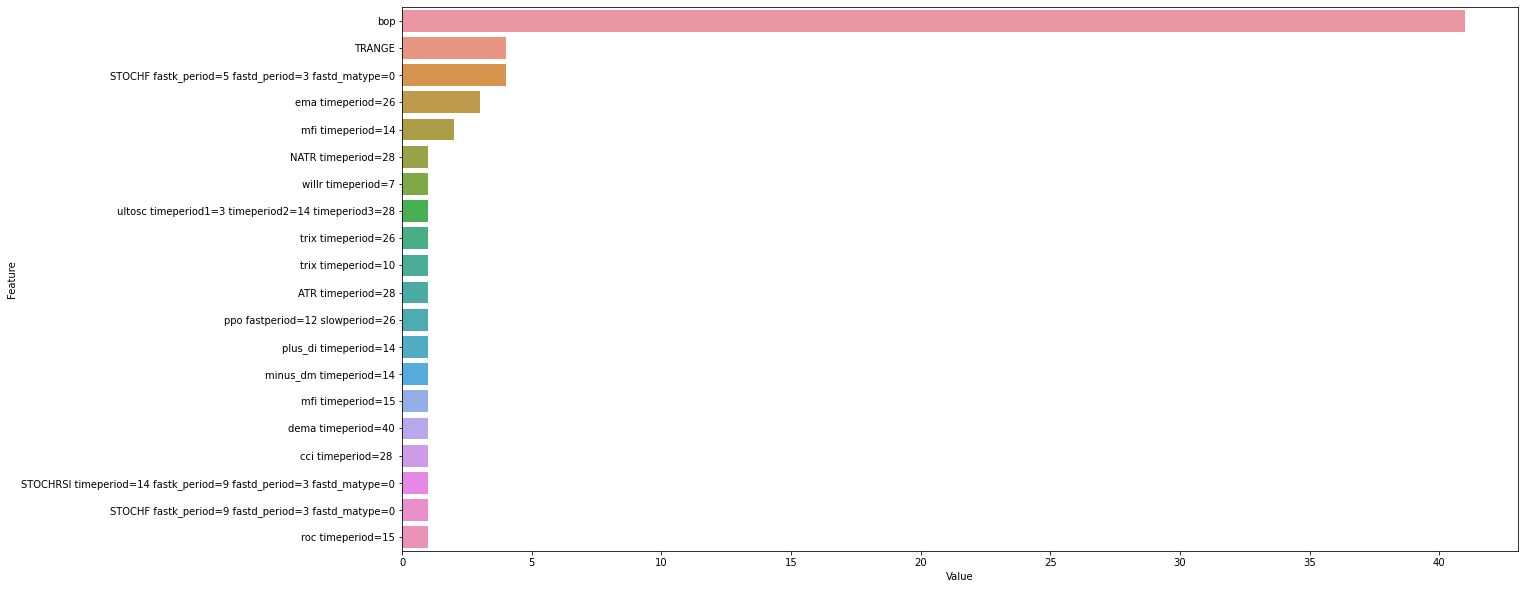

In [61]:
#TOP 20 features
plt.figure(figsize=(20, 10))
fig=sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
img = fig.get_figure()

<h3> Save the Model <h3>

In [ ]:
# save model
modelname = stockid + 'gbmm_odel1.pkl'
joblib.dump(adj_lgbmc, modelname)